In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from skimage import data
from skimage.color import rgb2gray
from PIL import Image
import seaborn as sns

In [110]:
def read_img(path):
    img_to_recognize = img.imread(path)
    img_to_recognize = Image.fromarray(np.uint8(img_to_recognize))
    img_to_recognize = img_to_recognize.resize((150, 150))
    img_to_recognize = img_to_recognize.convert('L')
    img_to_recognize = np.array(img_to_recognize)
    return img_to_recognize.flatten()/255

In [111]:
def display_image_ind(matrix, index):
    # Displays the image present in the row_{index} of the specified matrix
    resized = np.resize(matrix[index], (150, 150))
    plt.imshow(resized, cmap="gray")


def display_image(matrix):
    # Displays the image present in the row_{index} of the specified matrix
    resized = np.resize(matrix, (150, 150))
    plt.imshow(resized, cmap="gray")


def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [112]:
avg_nicole = np.zeros((150, 150)) # Matrix that will later become the "average" image
nicoles = [] # List that will house all individual arrays of images, will become a matrix later
count = 1

for nicole in os.listdir('faces'):
    # Converts images to correct size and changes its color to grayscale
    img_nicole = img.imread(os.path.join('faces',nicole))
    img_nicole = Image.fromarray(np.uint8(img_nicole))
    img_nicole = img_nicole.convert('L')
    img_nicole = img_nicole.resize((150, 150))

    # Turns those images into an array and append them to a list that will become a matrix of images later
    array_nicole = np.array(img_nicole)
    avg_nicole += array_nicole
    nicoles.append(array_nicole.flatten()/255)


In [113]:
celebrity_photos=os.listdir('faces')
celebrity_names=[name[:name.find('0')-1].replace("_", " ") for name in celebrity_photos]


In [114]:
image_matrix = np.row_stack(tuple(nicoles))


In [115]:
def pca(X, n_pc):
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, Vh = np.linalg.svd(centered_data, full_matrices=False)
    components = Vh[:n_pc]
    # projected = U[:,:n_pc]*S[:n_pc]
    
    return components, mean, centered_data, S[:n_pc]


In [116]:
Vh, average_matrix, subtracted, eigenvalues = pca(image_matrix, n_pc=200)
eigenfaces = Vh.reshape((200, 150, 150))

KeyboardInterrupt: 

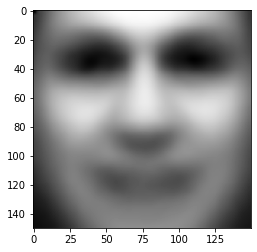

In [102]:
display_image(average_matrix)

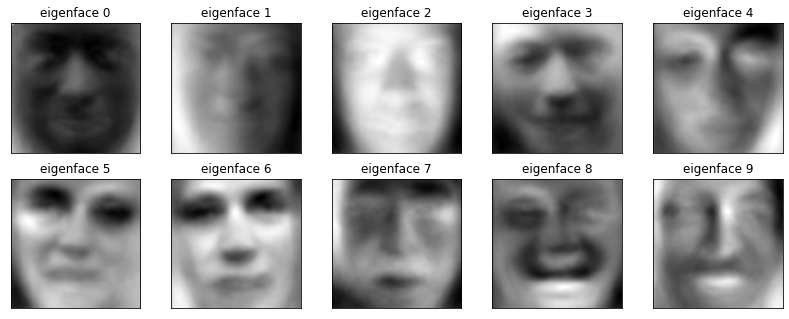

In [103]:
# eigenface_titles = [f"eigenface {200-i}" for i in range(eigenfaces.shape[0])]
# plot_portraits(eigenfaces[::-1], eigenface_titles, 150, 150, 2, 5) 
# plt.savefig('lowest_eigenfaces.png', bbox_inches='tight')

eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_portraits(eigenfaces, eigenface_titles, 150, 150, 2, 5) 
# plt.savefig('highest_eigenfaces.png', bbox_inches='tight')

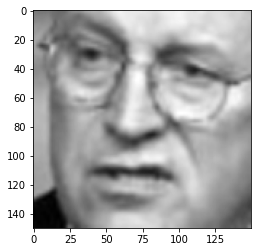

In [104]:
display_image_ind(image_matrix, 307)


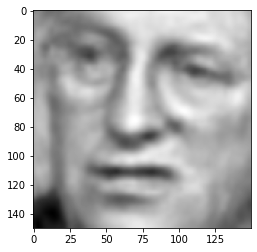

In [105]:
def reconstruction(sub, eigenfaces, mean, h, w, image_index):
    n_samples, n_features = sub.shape
    weights = np.dot(sub, eigenfaces.T)
    centered_vector=np.dot(weights[image_index, :], eigenfaces)
    recovered_image=(mean+centered_vector).reshape(h, w)
    return recovered_image

display_image(reconstruction(subtracted, Vh, average_matrix, 150, 150, 307))


(24.8842698285933, 'Paul Burrell')

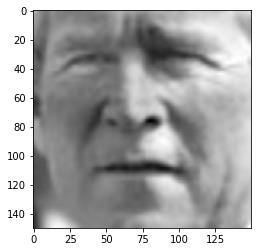

In [182]:
def recognize(nicole_num, eig_num):
    # Treats input image (the one we wish to recognize)
    #path = 'faces/Adrien_Brody_000' + str(nicole_num) + '.pgm'
    path = 'objects/bush' + str(nicole_num) + '.pgm'
    # path = 's3_' + str(nicole_num) + '.jpg'
    img_to_recognize = read_img(path)
    subtracted_matrix_rec = img_to_recognize - average_matrix
    display_image(subtracted_matrix_rec)
    subtracted_matrix_rec = subtracted_matrix_rec.flatten()
    # Projeção da imagem já subtraída da média no face space para obter o array de coeficientes (pesos de cada eigenface)
    eigenfaces_matrix = Vh[:eig_num,:]


    weight = np.dot(subtracted_matrix_rec, eigenfaces_matrix.T)


    # Value determines if the image is a face (to be chosen)
    projection = eigenfaces_matrix.T @ weight

    proj_error = np.linalg.norm(subtracted_matrix_rec*255 - projection*255)

    # Value determines which pic is related to to the input

    famous_faces_coeff = eigenfaces_matrix @ subtracted.T


    dist_in_space = []
    for i in range(len(subtracted[:,0])):
        dist = np.linalg.norm(famous_faces_coeff[:,i] - weight)
        dist_in_space.append(dist)
    
    dist_in_space = np.array(dist_in_space)

    groups = len(dist_in_space)//8
    dist_in_space = dist_in_space.reshape(groups, 8)

    dist_mean = dist_in_space.mean(axis=1)
    face_error = dist_mean.min()

    # Trying to get the right face (range of valid error still to be determined)
    guess_index = np.argmin(dist_mean)
    
    celebrity_name = celebrity_names[(guess_index)*8]
    return face_error, celebrity_name
    


recognize(2,100)
    

In [191]:
def recognize2(nicole_num, eig_num):
    # Treats input image (the one we wish to recognize)
    #path = 'faces/Luiz_Inacio_Lula_da_Silva_000' + str(nicole_num) + '.pgm'
    path = 'objects/nicole' + str(nicole_num) + '.jpg'
    # path = 's3_' + str(nicole_num) + '.jpg'
    img_to_recognize = read_img(path)
    subtracted_matrix_rec = img_to_recognize - average_matrix
    display_image(subtracted_matrix_rec)
    subtracted_matrix_rec = subtracted_matrix_rec.flatten()
    # Projeção da imagem já subtraída da média no face space para obter o array de coeficientes (pesos de cada eigenface)
    eigenfaces_matrix = Vh[:eig_num,:]

    weight = np.dot(subtracted_matrix_rec, eigenfaces_matrix.T)


    # Value determines if the image is a face (to be chosen)
    projection = eigenfaces_matrix.T @ weight

    proj_error = np.linalg.norm(subtracted_matrix_rec*255 - projection*255)

    # Value determines which pic is related to to the input

    famous_faces_coeff = eigenfaces_matrix @ subtracted.T


    dist_in_space = []
    for i in range(len(subtracted[:,0])):
        dist = np.linalg.norm(famous_faces_coeff[:,i]*255 - weight*255)
        dist_in_space.append(dist)
    
    dist_in_space = np.array(dist_in_space)

    face_error = dist_in_space.min()

    # Trying to get the right face (range of valid error still to be determined)
    guess_index = np.argmin(dist_in_space)
    
    celebrity_name = celebrity_names[guess_index]
    return proj_error, face_error, celebrity_name
    

(2723.227217723274, 27.24884032417223, 'Wen Jiabao')

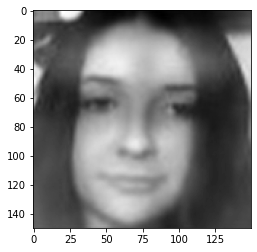

In [189]:
recognize2(1,100)

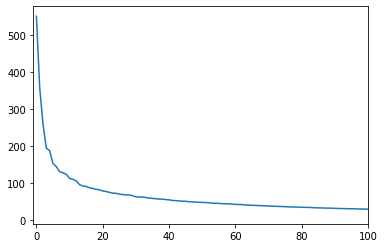

In [107]:
plt.plot(eigenvalues)
plt.xticks(range(0,200,20))
plt.xlim(-1, 100)
plt.show()